<h1>BCG - Data Science and Analytics Experience Program (Forage)</h1>

<h4>Notebook do código executado na segunda etapa do programa de experiência em Data Science da BCG, baseado em um case real. Nesse caso o objetivo é identificar o perfil do consumo e do produto e estabelecer uma métrica de sensibilidade ao preço, para posterior criação de modelo de previsão de churn</h4>

<h3>0. Importação das bibliotecas e definição de funções base</h3>

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

import warnings
warnings.filterwarnings("ignore")

In [19]:

def plot_hist_variaveis(conjunto, dataframe, i=0, legend=None, title='distribuição das variáveis numéricas'):
    
    '''
    Essa função plota uma série de histogramas a partir de um dado
    conjunto de colunas em um dataframe, o conjunto deve ser passado como
    uma lista. É possível criar segmentação nos dados através do parâmetro
    'legend', além disso também é possível alterar o título do gráfico
    através do parâmetro 'title'.
    '''

    total_plots = len(conjunto)
    fig = plt.figure(figsize=(20,6*total_plots))
    fig.subplots_adjust(hspace=0.4, wspace=0.3)
    fig.suptitle(title, y=0.895)


    for var in conjunto:
        mean = dataframe[var].mean()
        max = dataframe[var].max()
        first_quartile = dataframe[var].quantile(0.25)
        third_quartile = dataframe[var].quantile(0.75)
        ax = fig.add_subplot(total_plots, 2, i+1)
        if legend is not None:
            sns.histplot(x=dataframe[var], ax=ax, color='#435058', hue=dataframe[legend], alpha=0.5, kde=True)
        else:
            sns.histplot(x=dataframe[var], ax=ax, color='#435058', alpha=0.5,  kde=True)
        ax.set_title(var)
        ax.set_ylabel('')
        ax.set_xlabel('')
        ax.axvline(mean, color='r', linestyle='--')
        ax.axvline(first_quartile, color='g', linestyle='--')
        ax.axvline(third_quartile, color='g', linestyle='--')
        ax.text(ax.get_xlim()[0], ax.get_ylim()[1]+((ax.get_ylim()[1])/11), 'Média: {:.2f}'.format(mean))
        ax.text(ax.get_xlim()[0], ax.get_ylim()[1]+((ax.get_ylim()[1])/20), 'Máximo: {:.2f}'.format(max))
        
        i += 1

def plot_bar_variaveis(conjunto, dataframe, x_var, i=0, title='distribuição das variáveis numéricas', legend=None, annotate=None):
    
    '''
    Essa função plota uma série de barras a partir de um dado
    conjunto de colunas em um dataframe, o conjunto deve ser passado como
    uma lista. É possível criar segmentação nos dados através do parâmetro
    'legend', além disso também é possível alterar o título do gráfico
    através do parâmetro 'title'. O parâmetro 'annotate' coloca o label
    nas barras.
    '''

    total_plots = len(conjunto)
    fig = plt.figure(figsize=(20,6*total_plots))
    fig.subplots_adjust(hspace=0.4, wspace=0.3)
    fig.suptitle(title, y=0.895)

    for var in conjunto:
        ax = fig.add_subplot(total_plots, 2, i+1)
        #dataframe = dataframe.groupby(x_var).mean()

        if legend is not None:
            sns.barplot(y=dataframe[var], ax=ax, x=dataframe[x_var], hue=dataframe[legend])
        else:
            sns.barplot(y=dataframe[var], ax=ax, x=dataframe[x_var])

        if annotate:
            for p in ax.patches:
                x = p.get_x() + p.get_width()/2
                y = p.get_height()
                ax.annotate(f'{y:.2}', (x, y), ha='center', va='bottom', fontsize=10)
            
        ax.set_title(var)
        ax.set_ylabel('')
        ax.set_xlabel('')


        i += 1

def create_log_variable (conjunto, dataframe):
    '''
    Função simples que aceita um conjunto de colunas em 
    um dataframe e cria novas colunas com as versões logaritmicas
    dessas. Aceita apenas colunas numéricas e, em caso de 0, não
    realiza nenhuma alteração no valor.
    '''

    for var in conjunto:
        dataframe[var+'_log'] = dataframe[var].apply(lambda x: np.log(x) if x > 0 else 0)
    return dataframe

def normalization_test (conjunto, dataframe, alpha=0.05):
    '''
    Dado um conjunto de colunas em um dataframe, realiza
    testes de normalização a partir de Shapiro-Wilk e retorna 
    se o teste refuta ou não a hipótese nula. (H0 = Normal distribution)
    '''
    for col in conjunto:
        statistic, p_value = stats.shapiro(dataframe[col])
        if p_value > alpha:
            print(col, 'H0: Normal distribution')
        else:
            print(col, 'H1: Non-normal distribution')

def plot_bar_percentages(dataframe, var, rotation=0, fig=None, ax=None):
    ''' 
    Dada uma determinada coluna de um dataframe, devolve um gráfico
    de barras com os valores percentuais dos valores únicos da coluna.
    Pode ser configurado dentro de uma figura, se os parâmetros de figura
    e axis forem fornecidos
    '''
    count_dataframe = dataframe[[var]].value_counts().reset_index(name='count')
    count_dataframe['percentage'] = count_dataframe['count'] / count_dataframe['count'].sum()

    if fig is None and ax is None:
        fig, ax = plt.subplots(figsize=(10,6))
        sns.barplot(x=var, y='percentage', data=count_dataframe)
    else:
        sns.barplot(x=var, y='percentage', data=count_dataframe, ax=ax)

    for p in ax.patches:
        x = p.get_x() + p.get_width()/2
        y = p.get_height()
        ax.annotate(f'{y:.2%}', (x, y), ha='center', va='bottom', fontsize=10)
 
    
    plt.xticks(rotation=rotation)

    

<h3>1. Importação e união dos csvs</h3>

In [20]:
#São fornecidos dois datasets, relacionados aos clientes e aos preços dos produtos
dir_price = 'price_data.csv'
dir_client = 'client_data.csv'

df_price = pd.read_csv(dir_price)
df_client = pd.read_csv(dir_client)

In [21]:
#Foi considerada que a perda de informação pela junção dos csvs seria baixa se considerado o número de linhas, assim, os dataframes foram unidos para melhoria na leitura
for dataframe in [df_client, df_price]:
    print(dataframe['id'].nunique())
    print(dataframe.shape)

df = df_client.merge(df_price, how='inner', on='id')
print(df['id'].nunique())
print(df.shape)

14606
(14606, 26)
16096
(193002, 8)
14606
(175149, 33)


<h3>2. Manipulação do dataframe</h3>

In [22]:
#Verificando as informações sobre o dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 175149 entries, 0 to 175148
Data columns (total 33 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   id                              175149 non-null  object 
 1   channel_sales                   175149 non-null  object 
 2   cons_12m                        175149 non-null  int64  
 3   cons_gas_12m                    175149 non-null  int64  
 4   cons_last_month                 175149 non-null  int64  
 5   date_activ                      175149 non-null  object 
 6   date_end                        175149 non-null  object 
 7   date_modif_prod                 175149 non-null  object 
 8   date_renewal                    175149 non-null  object 
 9   forecast_cons_12m               175149 non-null  float64
 10  forecast_cons_year              175149 non-null  int64  
 11  forecast_discount_energy        175149 non-null  float64
 12  forecast_meter_r

In [23]:
#Removendo linhas duplicadas do dataset
df = df.drop_duplicates()

In [24]:
#As colunas "channel_sales" e "origin_up" têm valores com nomes estranhos e que dizem pouco, assim, foram atribuídos códigos numéricos para facilitar a compreensão da mesma"
for var in ['channel_sales','origin_up']:
    df[var] = df[var].factorize()[0]

In [25]:
#Como as datas apresentam valores diários, criei colunas com os valores anuais de variáveis do tipo date, procurando simplificar a leitura posteior
for var in ['date_activ', 'date_end', 'date_modif_prod', 'date_renewal']:
    df[var] = pd.to_datetime(df[var], format='%Y-%m-%d')


df['year_activ'] = df['date_activ'].dt.year
df['year_renewal'] = df['date_renewal'].dt.year
df['year_modif_prod'] = df['date_modif_prod'].dt.year
df['year_end'] = df['date_end'].dt.year


<h3>3. Visualização dos dados e insights</h3>

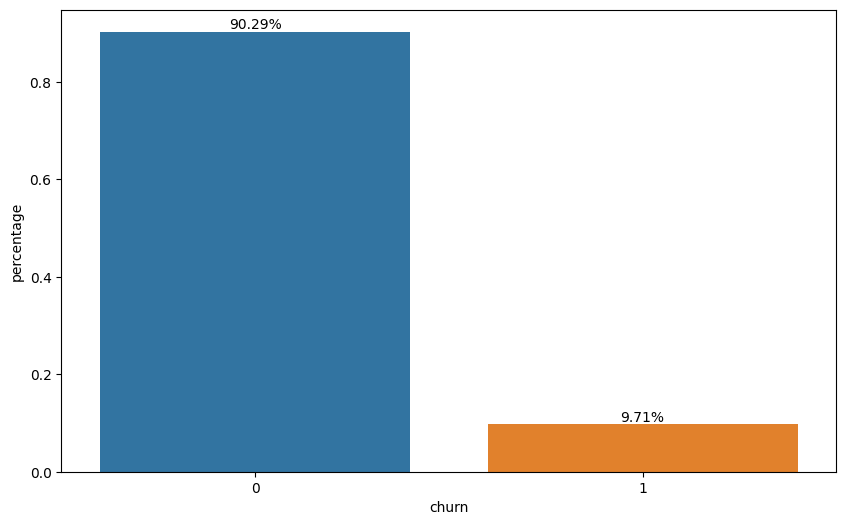

In [26]:
plot_bar_percentages(dataframe=df, var='churn')

<h4>O primeiro passo na análise é o de verificar o tamanho do problema. Nesse caso, cerca de 10% dos clientes realizaram churn no período.</h4>

In [27]:
#Separei o dataframe em dois, a partir do conhecimento de se o churn ocorreu ou não. A intenção aqui é a de analisar comparativamente algumas variáveis numéricas a fim de verificar diferenças quantitativas
#entre os grupos

df_had_churn = df[df['churn'] == 1]
df_not_churn = df[df['churn'] == 0]

Text(0.5, 1.0, 'Not Churn')

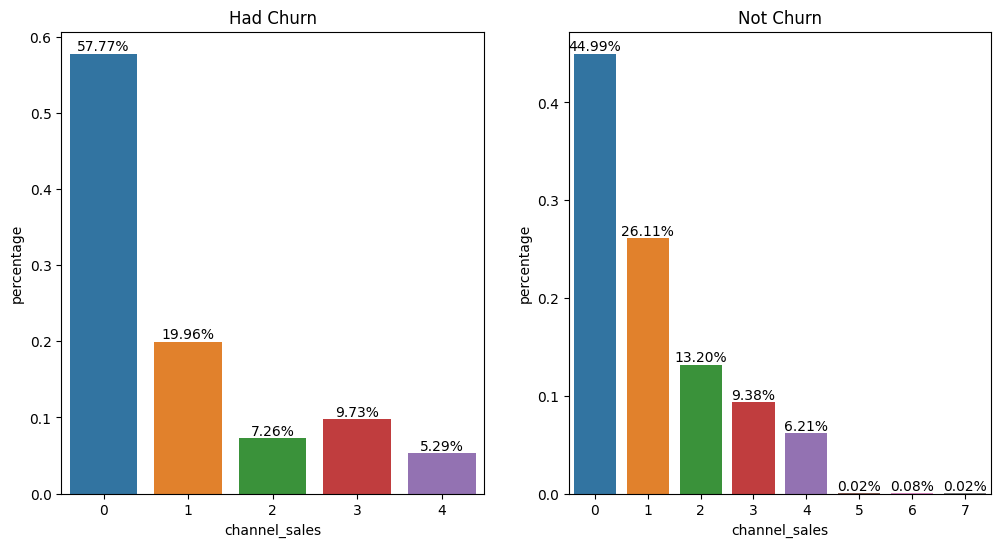

In [28]:
#Plotando o segmento pelo qual os clientes obtiveram a compra
fig, ax = plt.subplots(figsize=(12, 6), ncols=2, nrows=1)
plot_bar_percentages(df_had_churn, 'channel_sales', fig=fig, ax=ax[0])
plot_bar_percentages(df_not_churn, 'channel_sales', fig=fig, ax=ax[1])
ax[0].set_title('Had Churn')
ax[1].set_title('Not Churn')

<h4>Os canais 5, 6 e 7 não tiveram muita expressão nas compras, a distribuição da participação entre os canais de compra nos clientes que realizaram ou não o churn é relativamente semelhante, o que indica que não deve haver uma correlação muito forte nesse caso.</h4>

Text(0.5, 1.0, 'Not Churn')

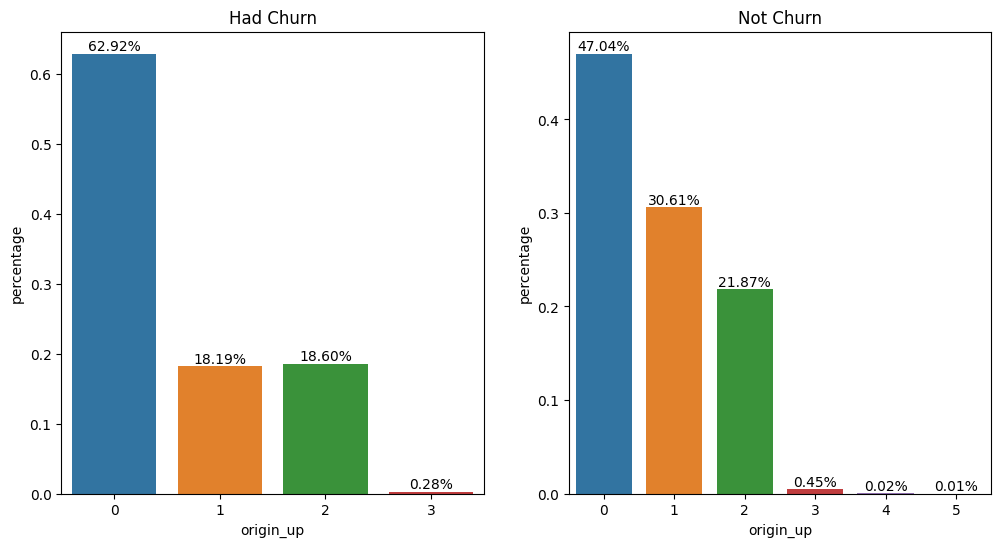

In [29]:
#Plotando a promoção pelo qual os clientes obtiveram o produto
fig, ax = plt.subplots(figsize=(12, 6), ncols=2, nrows=1)
plot_bar_percentages(df_had_churn, 'origin_up', fig=fig, ax=ax[0])
plot_bar_percentages(df_not_churn, 'origin_up', fig=fig, ax=ax[1])
ax[0].set_title('Had Churn')
ax[1].set_title('Not Churn')

<h4>As promoções 0, 1 e 2 tiveram maior adesão de novos clientes. A campanha 1 apresenta sucesso na retenção dos clientes, no sentido de ter mantido um percentual consideravelmente alto entre os atuais clientes da base, mais da metade dos clientes que realizaram churn obtiveram o produto pela campanha 0</h4>

Text(0.5, 1.0, 'Not Churn')

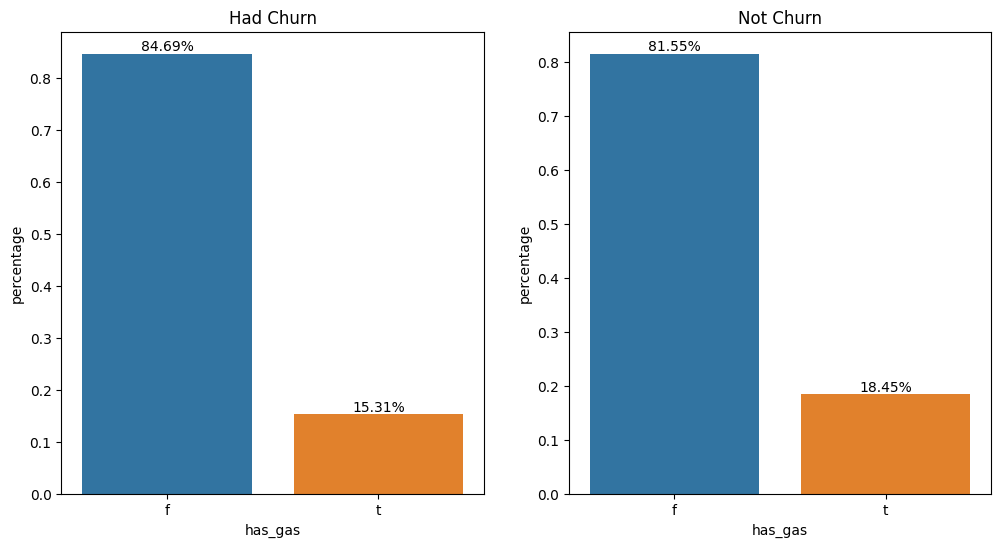

In [30]:
#Plotando o percentual de clientes que possuem energia a gás
fig, ax = plt.subplots(figsize=(12, 6), ncols=2, nrows=1)
plot_bar_percentages(df_had_churn, 'has_gas', fig=fig, ax=ax[0])
plot_bar_percentages(df_not_churn, 'has_gas', fig=fig, ax=ax[1])
ax[0].set_title('Had Churn')
ax[1].set_title('Not Churn')

<h4>Não há diferença substancial no perfil entre os clientes, o que indica que o fato de consumir energia à gás não é um diferencial na previsão de churn</h4>

Text(0.5, 0.98, 'Alterações no contrato de serviço por ano')

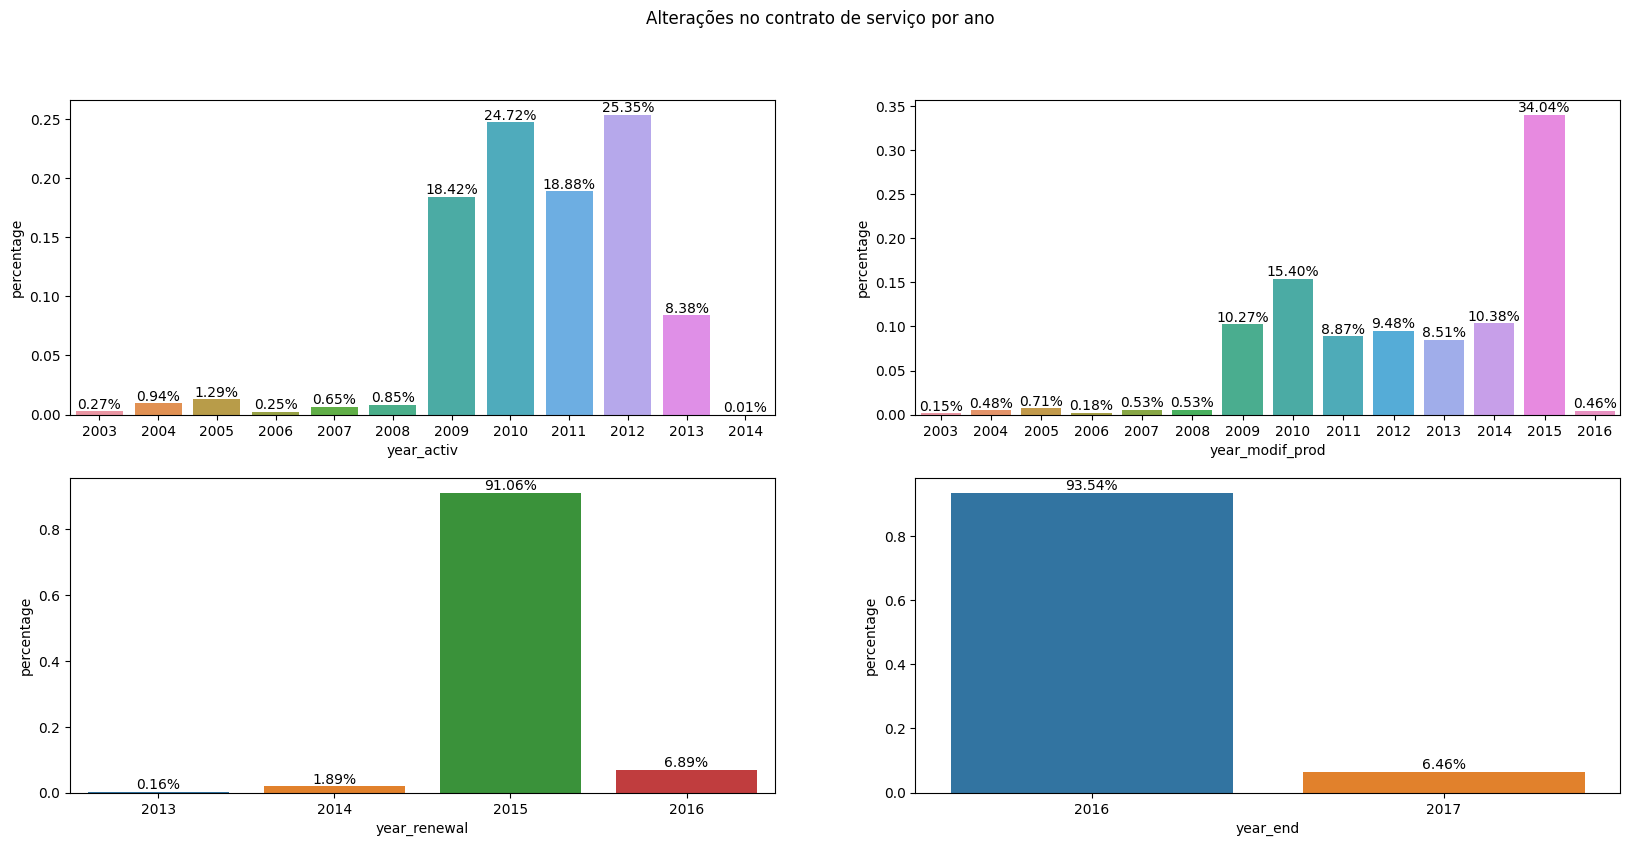

In [31]:
#Plotando as alterações de contrato de serviço por ano 
fig, ax = plt.subplots(figsize=(20, 9), ncols=2, nrows=2)
plot_bar_percentages(df, 'year_activ', fig=fig, ax=ax[0][0])
plot_bar_percentages(df, 'year_modif_prod', fig=fig, ax=ax[0][1])
plot_bar_percentages(df, 'year_renewal', fig=fig, ax=ax[1][0])
plot_bar_percentages(df, 'year_end', fig=fig, ax=ax[1][1])

'''for ax_ in ax:
    ax_.tick_params(axis='x', rotation=90)'''

fig.suptitle('Alterações no contrato de serviço por ano')

<h4>A maioria dos contratos foi firmada entre 2009 e 2013, anos com expressiva participação, também, na modificação dos contratos. No entanto, é em 2015 que se verifica um ponto de virada, uma vez que é ano onde ocorre a grande maioria das modificações e renovações de contrato; o ano posterior, 2016, é o momento da grande maioria do churn, o que pode indicar, primeiro que esse seria o ano de renovação do contrato (uma vez que vários contratos foram renovados em 2015, é intuitivo pensar que o ano posterior seguiria a mesma tendência). O churn em 2016 também pode ser um indicativo da insatisfação com a modificação com o contrato nos anos anteriores ou com a renovação de contrato realizada previamente. Sabendo que a renovação de contrato normalmente implica uma modificação nos valores, um hipótese plausível é que os valores firmados nos novos contratos não foram atrativos para uma quantidade considerável dos clientes.</h4>

Text(0.5, 0.98, 'Energy price variation')

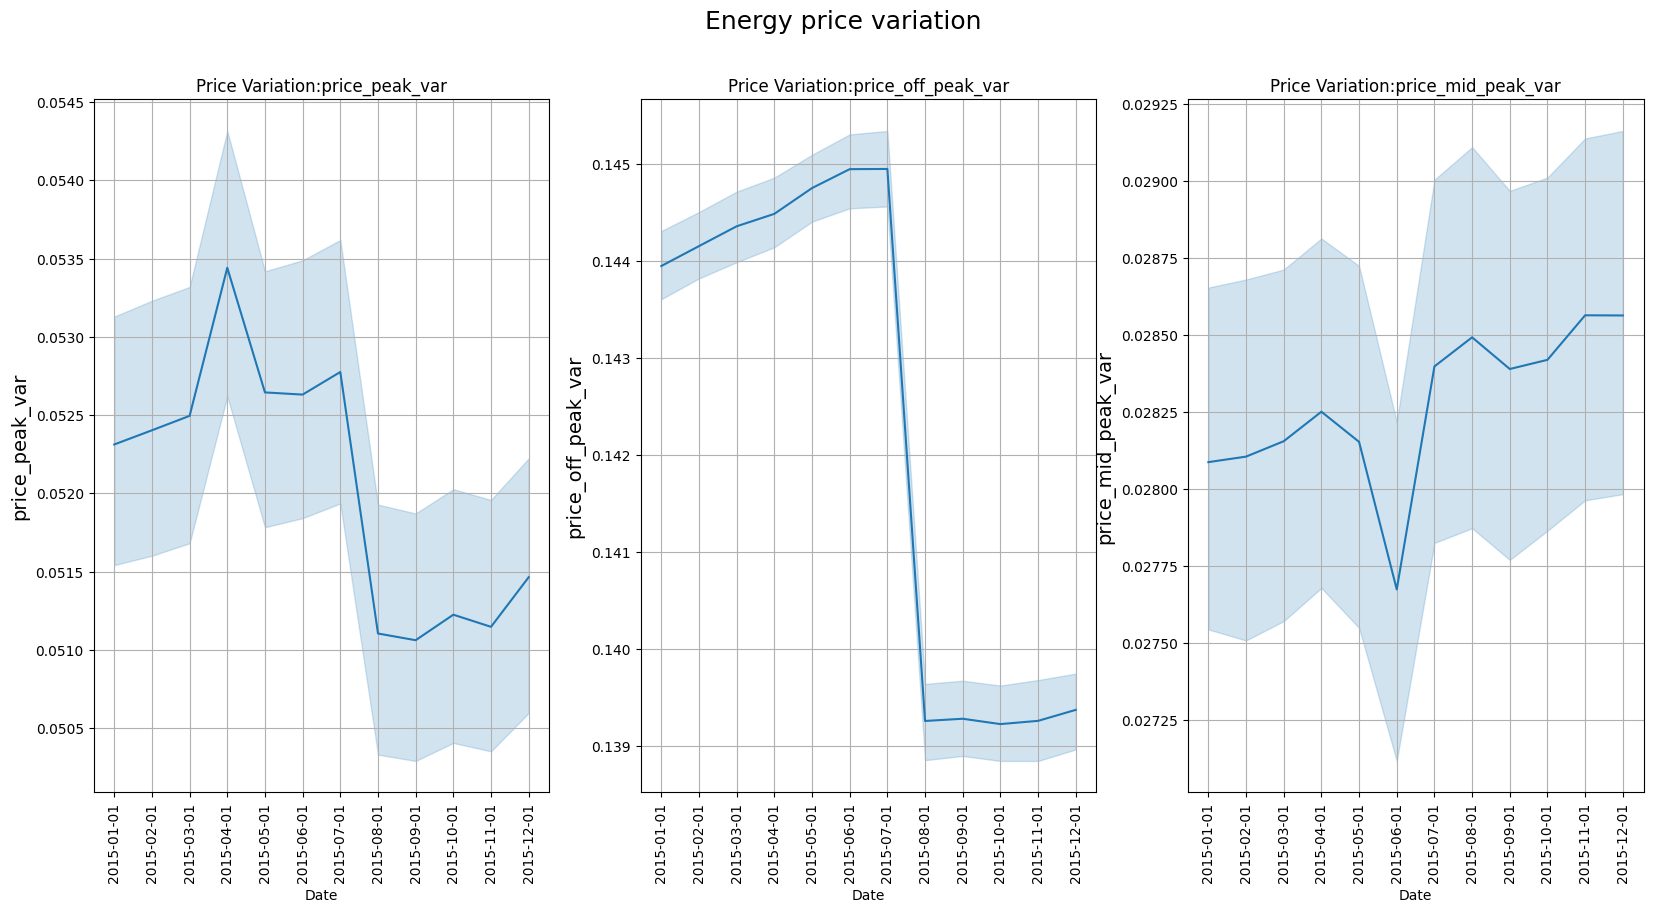

In [32]:
#Plotando as variações de preço da energia
fig, ax = plt.subplots(figsize=(20, 9), nrows=1, ncols=3)
sns.lineplot(x='price_date', y='price_peak_var', data=df, ax=ax[0])
sns.lineplot(x='price_date', y='price_off_peak_var', data=df, ax=ax[1])
sns.lineplot(x='price_date', y='price_mid_peak_var', data=df, ax=ax[2])

for ax_ in ax:
    ax_.set_xlabel('Date')
    ax_.set_ylabel(ax_.get_ylabel(), fontsize=14)
    ax_.set_title('Price Variation:' + ax_.get_ylabel())
    ax_.tick_params(axis='x', rotation=90)
    ax_.grid(True)

fig.suptitle('Energy price variation', fontsize=18)

#%%

Text(0.5, 0.98, 'Power price variation')

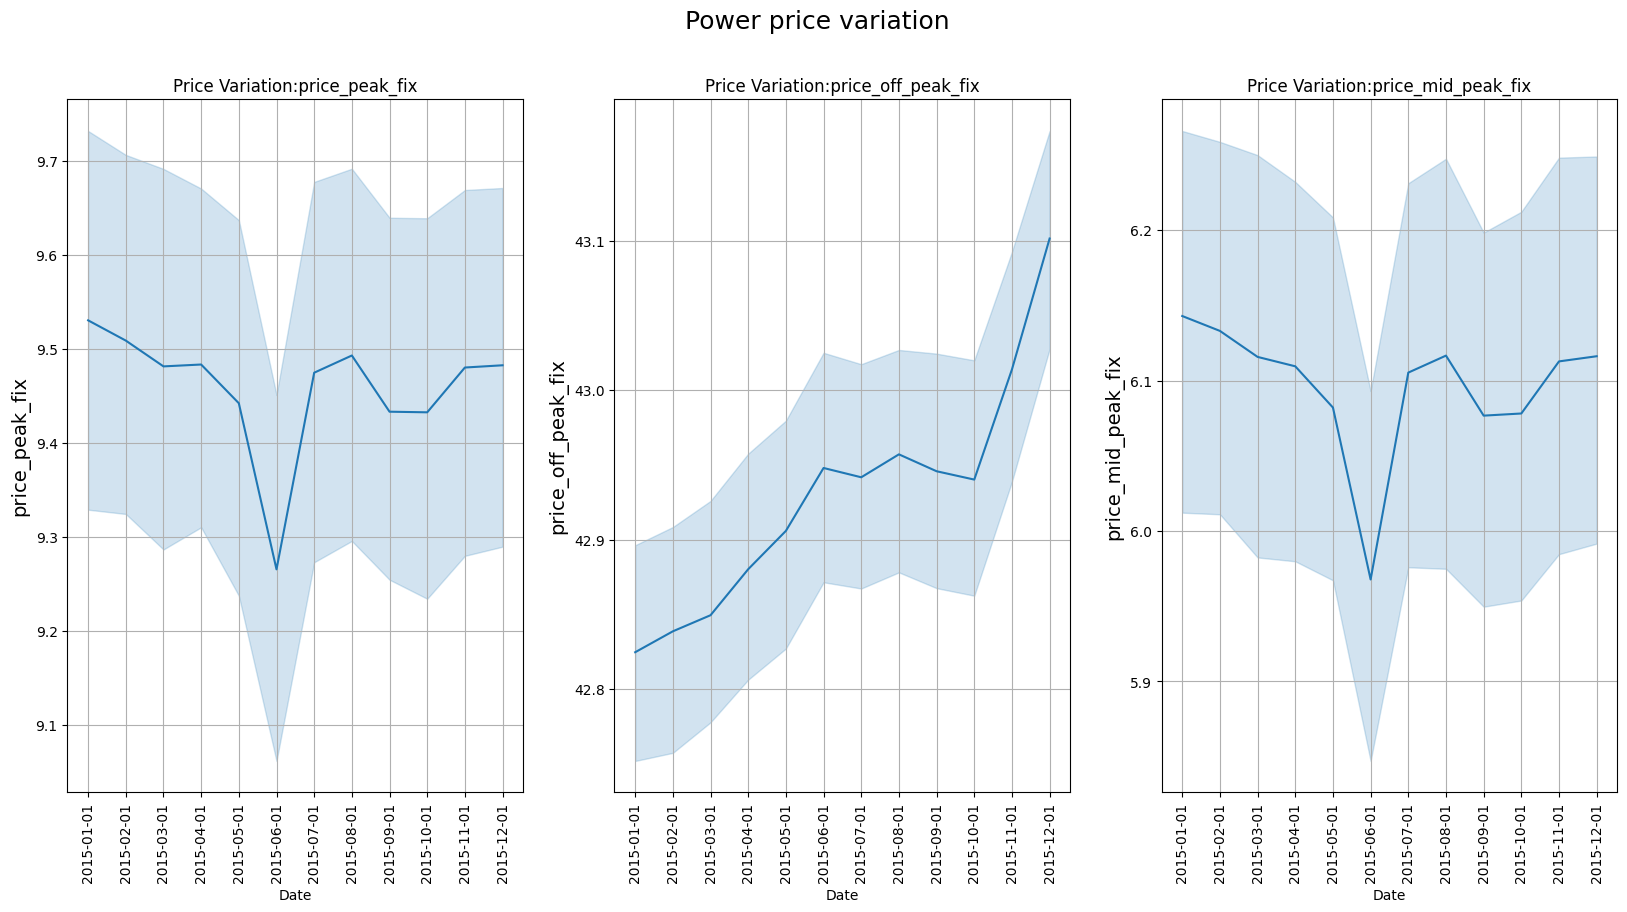

In [33]:
#Plotando as variações de preço da força
fig, ax = plt.subplots(figsize=(20, 9), nrows=1, ncols=3)
sns.lineplot(x='price_date', y='price_peak_fix', data=df, ax=ax[0])
sns.lineplot(x='price_date', y='price_off_peak_fix', data=df, ax=ax[1])
sns.lineplot(x='price_date', y='price_mid_peak_fix', data=df, ax=ax[2])

for ax_ in ax:
    ax_.set_xlabel('Date')
    ax_.set_ylabel(ax_.get_ylabel(), fontsize=14)
    ax_.set_title('Price Variation:' + ax_.get_ylabel())
    ax_.tick_params(axis='x', rotation=90)
    ax_.grid(True)

fig.suptitle('Power price variation', fontsize=18)

<h4>A inspeção dos gráficos aponta que os preços de energia diminuíram ao longo de 2015, no entanto, o preço da força do período fora-ponta aumentou consideravelmente no mesmo ano. Esse pode ser um indicativo da relação dessa variável com o movimento de churn no ano seguinte. Caso a relação seja comprovada, o preço da força no período fora-ponta seria o mais decisivo na tomada de decisão dos clientes, o que faz algum sentido visto que a tarifa fica nessa faixa durante a maior parte do dia</h4>

In [34]:
#Separei alguns grupos de variáveis e agrupei os valores numéricos pela média a partir da condição de churn. O intuito aqui é verificar se existem diferenças substanciais entre os grupos para algumas
#dessas variáveis
vars_consumo = ['cons_12m', 'cons_gas_12m', 'cons_last_month']
vars_consumo_previsto = ['forecast_cons_12m', 'forecast_cons_year']
vars_consumo_pago = ['imp_cons']
vars_lucro = ['margin_gross_pow_ele', 'margin_net_pow_ele', 'net_margin']
vars_produto = ['num_years_antig', 'nb_prod_act', 'pow_max']

df_churn_mean = df.groupby('churn', as_index=False).mean()

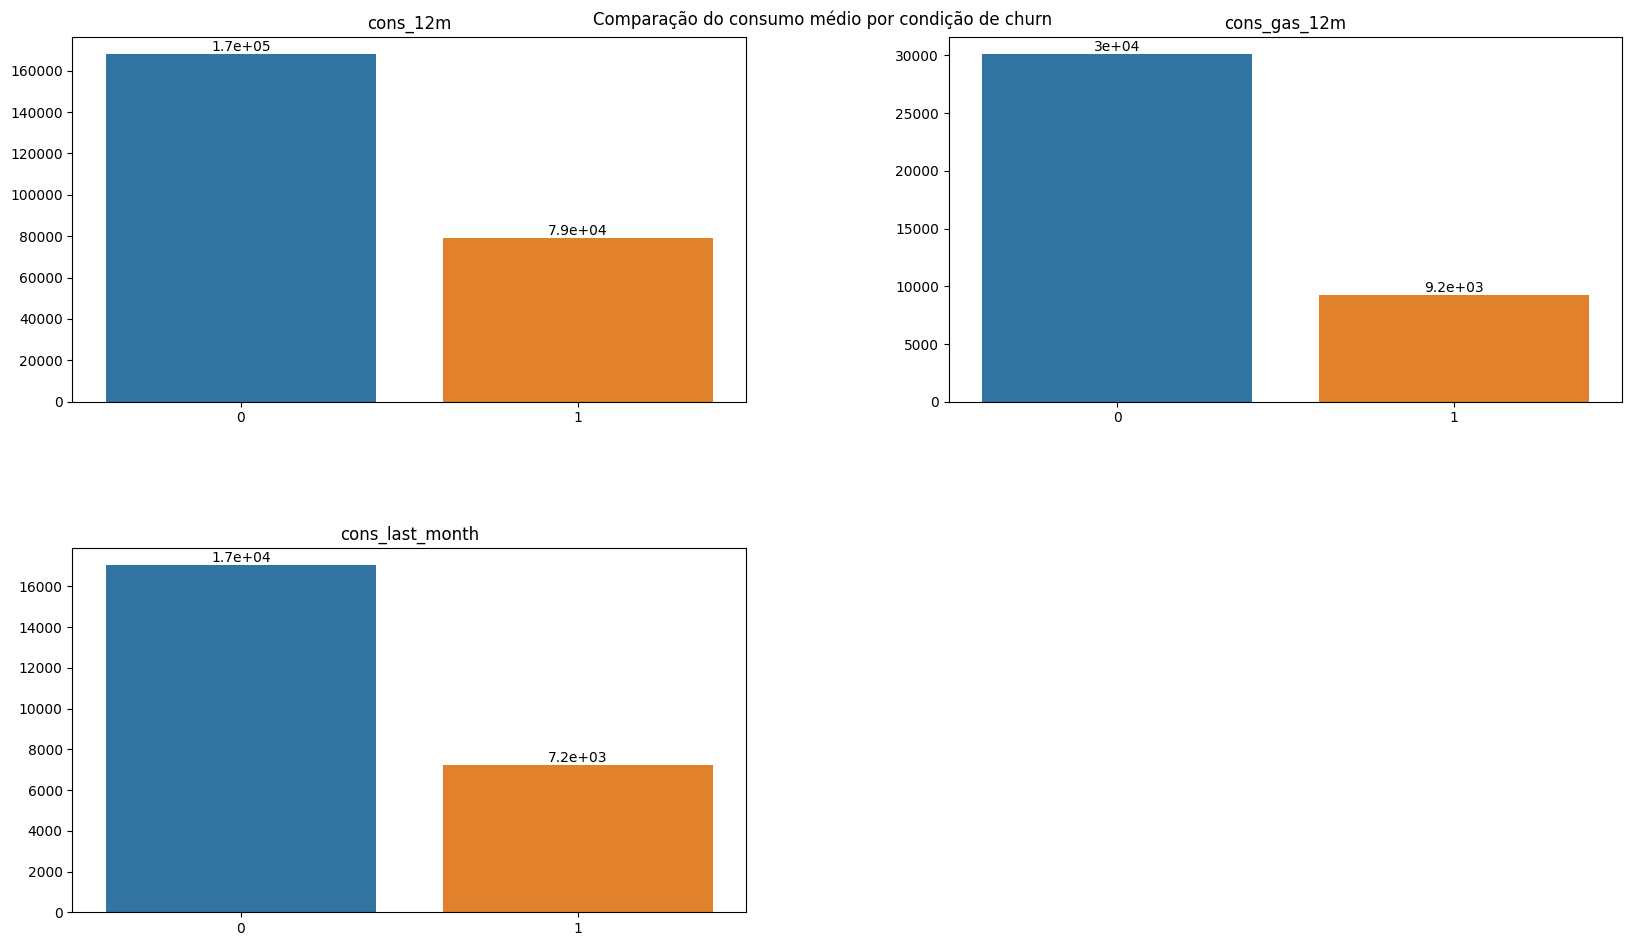

In [35]:
plot_bar_variaveis(conjunto=vars_consumo, dataframe=df_churn_mean, x_var='churn', annotate=True, title='Comparação do consumo médio por condição de churn')

<h4>O consumo médio nos últimos 12 meses e no último mês foi consideravelmente menor entre os clientes que realizaram churn, essa é uma constatação importante, uma vez que permite investigar possíveis novos candidatos ao churn a partir do consumo desses nos últimos meses. Também é interessante pensar se a diminuição do consumo está relacionada com o aumento dos preços, nesse sentido, é razoável pensar que empresas mais afetadas pelo aumento do preço diminuem mais o consumo e ocasionalmente trocam de fornecedor. Existe, ainda, a hipótese de que clientes menores - e provavelmente com menor consumo - são mais afetados pelo aumento dos preços e por isso realizam mais churn, mas é difícil confirmar essa hipótese uma vez que existem poucas informações sobre os clientes</h4>

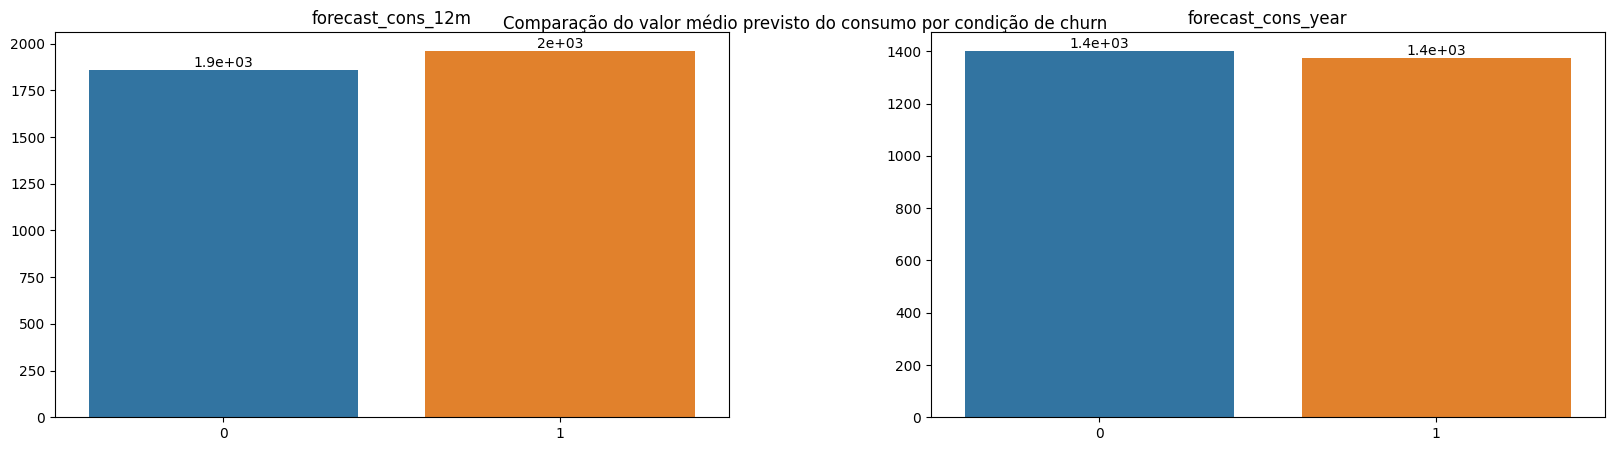

In [36]:
plot_bar_variaveis(conjunto=vars_consumo_previsto, dataframe=df_churn_mean, x_var='churn', annotate=True, title='Comparação do valor médio previsto do consumo por condição de churn')

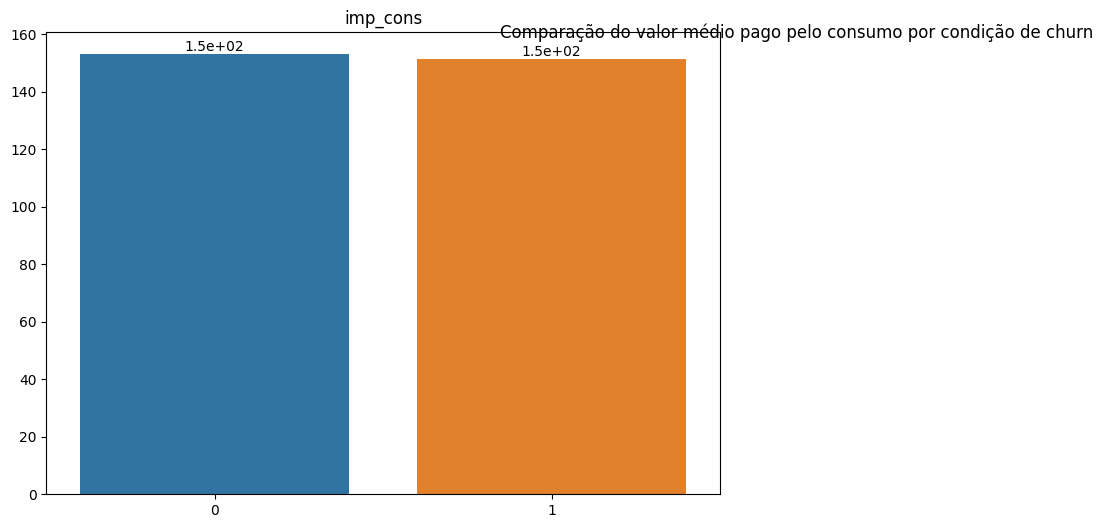

In [37]:
plot_bar_variaveis(conjunto=vars_consumo_pago, dataframe=df_churn_mean, x_var='churn', annotate=True, title='Comparação do valor médio pago pelo consumo por condição de churn')

<h4>Não há diferença significativa entre o consumo previsto para os próximos períodos entre os clientes. Essa averiguação indica que o menor consumo dos clientes que realizaram churn não deve estar relacionado com o tamanho das empresas ou necessidade de consumo, uma vez que, caso essa hipótese fosse verdadeira, o consumo previsto para os próximos meses seria consideravelmente mais baixo entre os clientes que realizaram churn. Assim, é possível afirmar - prematuramente - que foi uma surpresa o baixo consumo entre os clientes que realizaram churn</h4>

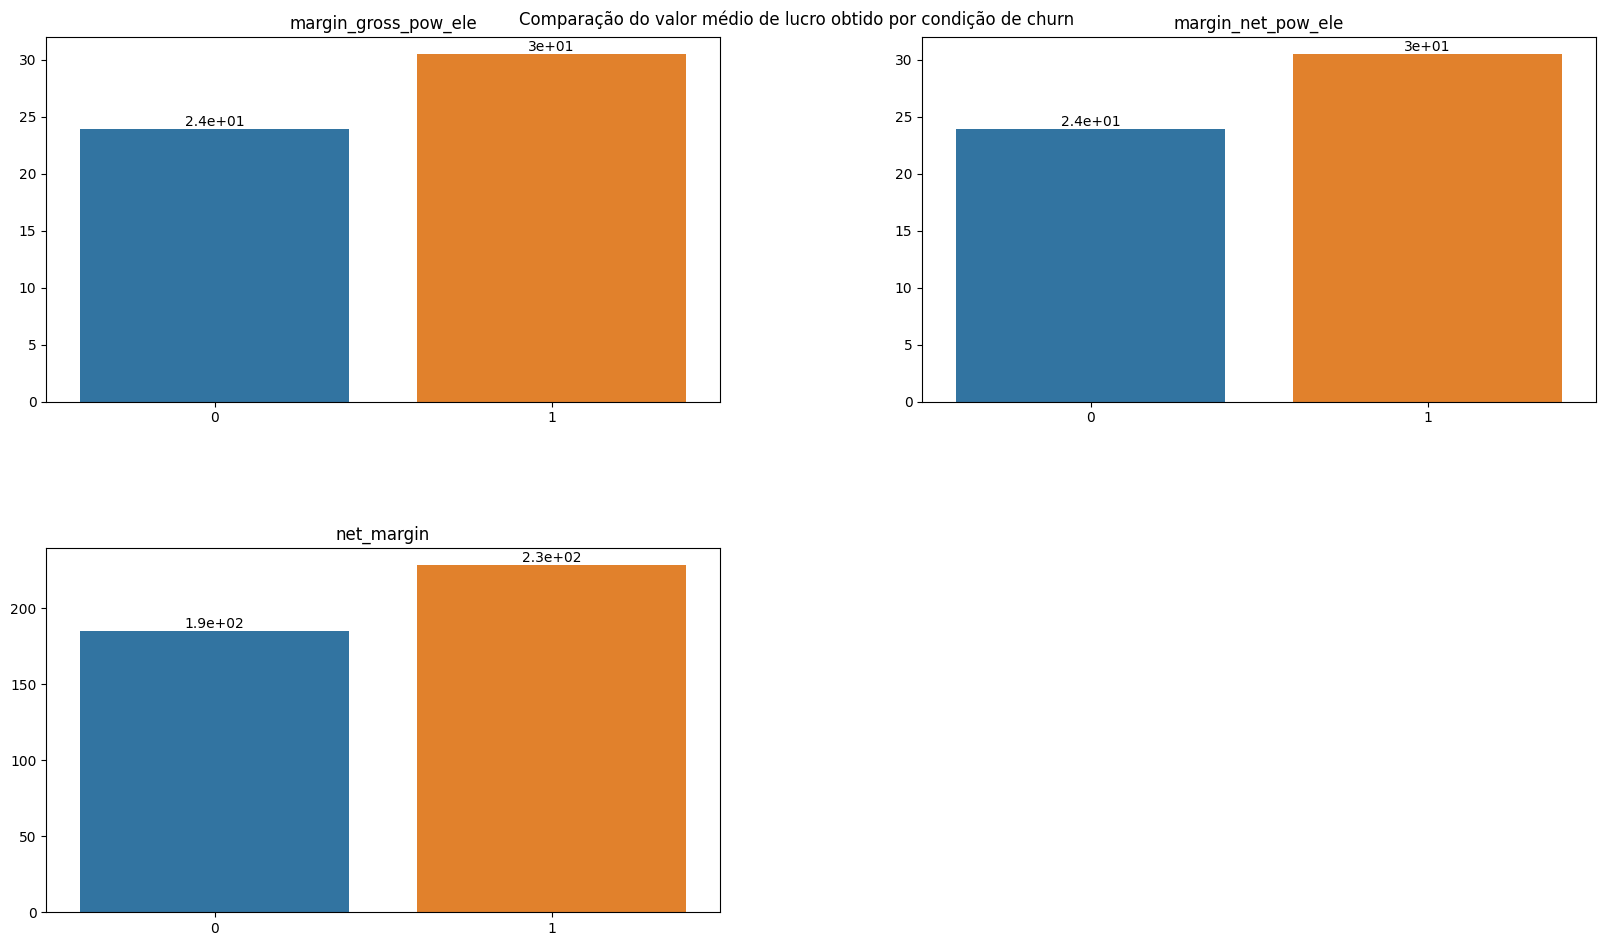

In [38]:
plot_bar_variaveis(conjunto=vars_lucro, dataframe=df_churn_mean, x_var='churn', annotate=True, title='Comparação do valor médio de lucro obtido por condição de churn')

<h4>A margem de lucro da empresa é maior entre os clientes que realizaram churn posteriormente. Esse pode ser um indicativo de que esses clientes aderiram a promoções menos vantajosas ou que pagam  proporcionalmente mais pelo consumo, mas também pode estar relacionadas com questões específicas dos clientes.</h4>

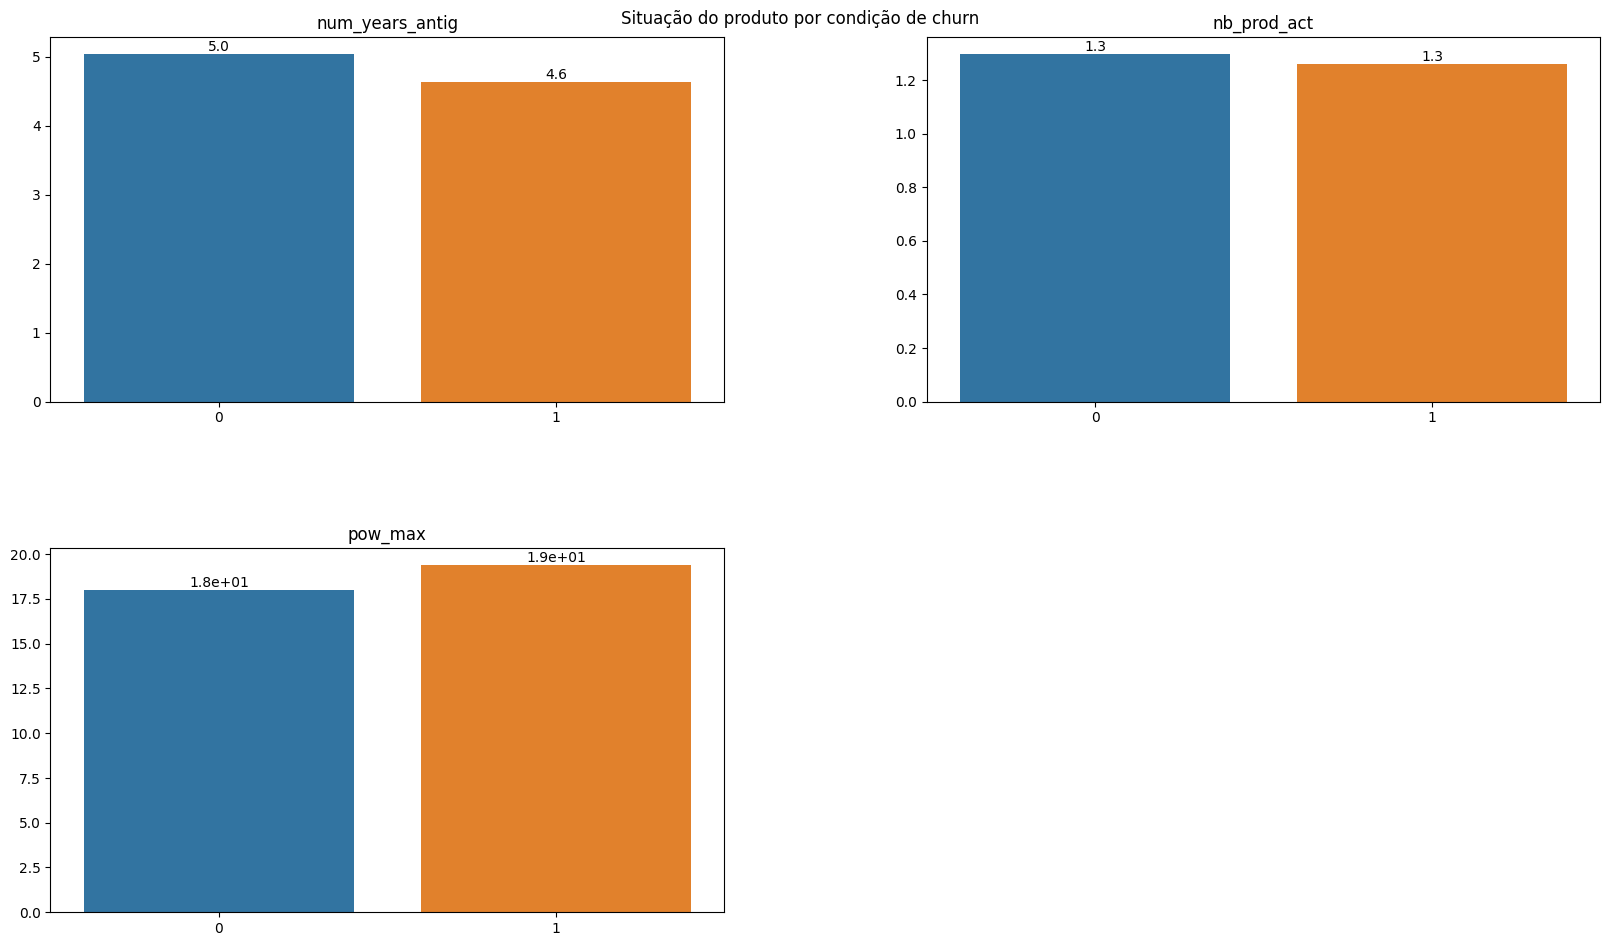

In [39]:
plot_bar_variaveis(conjunto=vars_produto, dataframe=df_churn_mean, x_var='churn', annotate=True, title='Situação do produto por condição de churn')

<h4>A condição das características dos clientes é relativamente semelhante em relação ao período ativo do contrato e o número de produtos adquiridos, a quantidade de força contratada também é parecida. Nesse caso, chama a atenção a equidade na força contratada, visto que o consumo entre os clientes que realizaram churn é consideravelmente menor.</h4>